In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
plt.style.use('ggplot')

from scipy import stats
from statsmodels.stats.proportion import proportions_ztest, proportion_confint, proportion_effectsize
from statsmodels.stats.power import NormalIndPower

## Exploratory Data Analysis

In [2]:
test_data = pd.read_csv("data/test_table.csv")
test_data.head()

,user_id,date,source,device,browser_language,ads_channel,browser,conversion,test
0,315281,2015-12-03,Direct,Web,ES,NaN,IE,1,0
1,497851,2015-12-04,Ads,Web,ES,Google,IE,0,1
2,848402,2015-12-04,Ads,Web,ES,Facebook,Chrome,0,0
3,290051,2015-12-03,Ads,Mobile,Other,Facebook,Android_App,0,1
4,548435,2015-11-30,Ads,Web,ES,Google,FireFox,0,1


In [3]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 453321 entries, 0 to 453320
Data columns (total 9 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   user_id           453321 non-null  int64 
 1   date              453321 non-null  object
 2   source            453321 non-null  object
 3   device            453321 non-null  object
 4   browser_language  453321 non-null  object
 5   ads_channel       181877 non-null  object
 6   browser           453321 non-null  object
 7   conversion        453321 non-null  int64 
 8   test              453321 non-null  int64 
dtypes: int64(3), object(6)
memory usage: 31.1+ MB


The column **ads_channel** has quite a lot of null values, but that just means that those users didn't visited the site via an ad. We can fill the null values with the string "None".

In [4]:
test_data["ads_channel"].fillna("None", inplace=True)

In [5]:
test_data["ads_channel"].value_counts()

None        271444
Facebook     68425
Google       68180
Yahoo        27435
Bing         13689
Other         4148
Name: ads_channel, dtype: int64

In [6]:
user_data = pd.read_csv("data/user_table.csv")
user_data.head()

,user_id,sex,age,country
0,765821,M,20,Mexico
1,343561,F,27,Nicaragua
2,118744,M,23,Colombia
3,987753,F,27,Venezuela
4,554597,F,20,Spain


In [7]:
user_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 452867 entries, 0 to 452866
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   user_id  452867 non-null  int64 
 1   sex      452867 non-null  object
 2   age      452867 non-null  int64 
 3   country  452867 non-null  object
dtypes: int64(2), object(2)
memory usage: 13.8+ MB


In [8]:
data = pd.merge(user_data, test_data, on="user_id")
data.head()

,user_id,sex,age,country,date,source,device,browser_language,ads_channel,browser,conversion,test
0,765821,M,20,Mexico,2015-12-02,Ads,Mobile,ES,Yahoo,Android_App,0,1
1,343561,F,27,Nicaragua,2015-12-04,Ads,Web,ES,Facebook,Safari,0,0
2,118744,M,23,Colombia,2015-11-30,Ads,Mobile,ES,Facebook,Android_App,0,1
3,987753,F,27,Venezuela,2015-12-04,SEO,Web,ES,None,IE,0,1
4,554597,F,20,Spain,2015-12-04,Direct,Web,ES,None,Chrome,0,0


In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 452867 entries, 0 to 452866
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   user_id           452867 non-null  int64 
 1   sex               452867 non-null  object
 2   age               452867 non-null  int64 
 3   country           452867 non-null  object
 4   date              452867 non-null  object
 5   source            452867 non-null  object
 6   device            452867 non-null  object
 7   browser_language  452867 non-null  object
 8   ads_channel       452867 non-null  object
 9   browser           452867 non-null  object
 10  conversion        452867 non-null  int64 
 11  test              452867 non-null  int64 
dtypes: int64(4), object(8)
memory usage: 44.9+ MB


In [10]:
len(data["user_id"].unique()) == len(data)

True

The merged data looks good. There are no missing values and no duplicate users.

## A/B Testing

<AxesSubplot:xlabel='test', ylabel='count'>

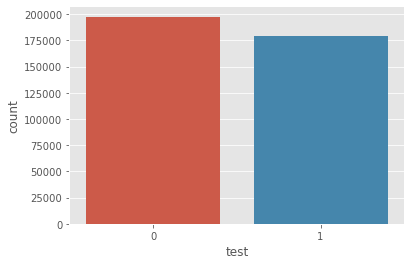

In [11]:
sns.countplot(x="test", data=data[data["browser_language"] == "ES"])

Splitting data into control and treatment sets.

In [12]:
control = data[(data["test"] == 0) & (data["browser_language"] == "ES")]
control.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 197562 entries, 1 to 452864
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   user_id           197562 non-null  int64 
 1   sex               197562 non-null  object
 2   age               197562 non-null  int64 
 3   country           197562 non-null  object
 4   date              197562 non-null  object
 5   source            197562 non-null  object
 6   device            197562 non-null  object
 7   browser_language  197562 non-null  object
 8   ads_channel       197562 non-null  object
 9   browser           197562 non-null  object
 10  conversion        197562 non-null  int64 
 11  test              197562 non-null  int64 
dtypes: int64(4), object(8)
memory usage: 19.6+ MB


In [13]:
treatment = data[(data["test"] == 1) & (data["browser_language"] == "ES")]
treatment.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 179598 entries, 0 to 452866
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   user_id           179598 non-null  int64 
 1   sex               179598 non-null  object
 2   age               179598 non-null  int64 
 3   country           179598 non-null  object
 4   date              179598 non-null  object
 5   source            179598 non-null  object
 6   device            179598 non-null  object
 7   browser_language  179598 non-null  object
 8   ads_channel       179598 non-null  object
 9   browser           179598 non-null  object
 10  conversion        179598 non-null  int64 
 11  test              179598 non-null  int64 
dtypes: int64(4), object(8)
memory usage: 17.8+ MB


In [14]:
print("Control mean:", np.mean(control["conversion"]))
print("Treatment mean:", np.mean(treatment["conversion"]))

Control mean: 0.05543070023587532
Treatment mean: 0.04351941558369247


Looks like the treatment performed worse than the control.

In [15]:
def proportion_test(control, treatment, country="", alternative="smaller"):
    successes = [control.sum(), treatment.sum()]
    nobs = [control.count(), treatment.count()]

    z_stat, pval = proportions_ztest(successes, nobs=nobs, alternative=alternative) # smaller: control < treatment
    (lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes, nobs=nobs, alpha=0.05)

    if country:
        print("Country: ", country)
    print(f'Z-statistic: {z_stat:.2f}')
    print(f'p-value: {pval:.3f}')
    print(f'ci 95% for control group: [{lower_con:.3f}, {upper_con:.3f}]')
    print(f'ci 95% for treatment group: [{lower_treat:.3f}, {upper_treat:.3f}]')
    print("Significant: ", "YES" if pval < 0.05 else "NO")

proportion_test(control["conversion"], treatment["conversion"], "", "larger")

Z-statistic: 16.80
p-value: 0.000
ci 95% for control group: [0.054, 0.056]
ci 95% for treatment group: [0.043, 0.044]
Significant:  YES


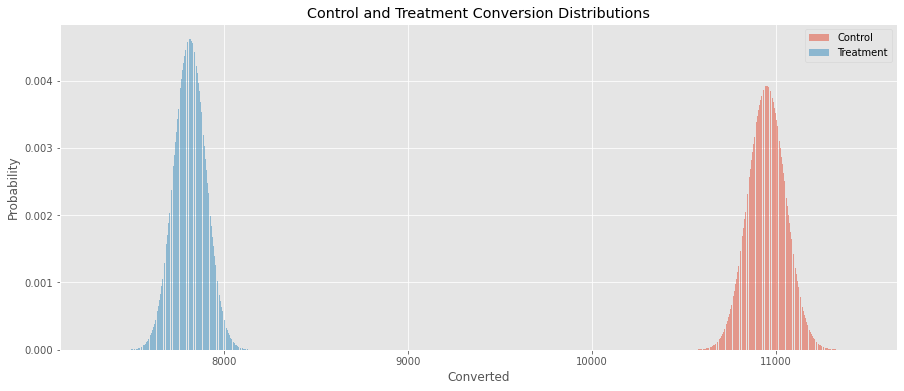

In [16]:
def plot_dist(control, treatment, title="Control and Treatment Conversion Distributions"):
    n_control = control.count()
    p_control = control.mean()

    n_treatment = treatment.count()
    p_treatment = treatment.mean()

    fig, ax = plt.subplots(figsize=(15,6))
    x = np.linspace(n_control*p_control-499, n_control*p_control+500, 1000)
    y = stats.binom(n_control, p_control).pmf(x)
    ax.bar(x, y, alpha=0.5, label="Control")
    # ax.axvline(x=n_treatment * p_treatment, c='blue', alpha=dd0.75, linestyle='--')
    x_t = np.linspace(n_treatment*p_treatment-499, n_treatment*p_treatment+500, 1000)
    y_t = stats.binom(n_treatment, p_treatment).pmf(x_t)
    ax.bar(x_t, y_t, alpha=0.5, label="Treatment")

    plt.title(title)
    plt.xlabel('Converted')
    plt.ylabel('Probability')
    plt.legend()

plot_dist(control["conversion"], treatment["conversion"])

Looking at the proportion test results, the z-statistic is huge, so the difference is significant. The plot also shows the two distributions are far apart from each other.

It appears that the localized versions of the site perform worse. 

## Investigation

Performing Power Analysis.

In [17]:
analysis = NormalIndPower()
effect = proportion_effectsize(control["conversion"].mean(), treatment["conversion"].mean())
power = 0.8
alpha = 0.05
result = analysis.solve_power(effect, power=power, nobs1=None, ratio=1.0, alpha=alpha)
print("Samples required:", round(result))
print("Control size:", len(control))
print("Treatment size:", len(treatment))

Samples required: 5185
Control size: 197562
Treatment size: 179598


To achieve significance of 5% and power of 80% with the given effect size, we need to have at least 5185 samples, which is a lot less than what we have in our test. So far, the experiment looks good.

Let's group the data by different features and see how they are split into control and treatment groups.

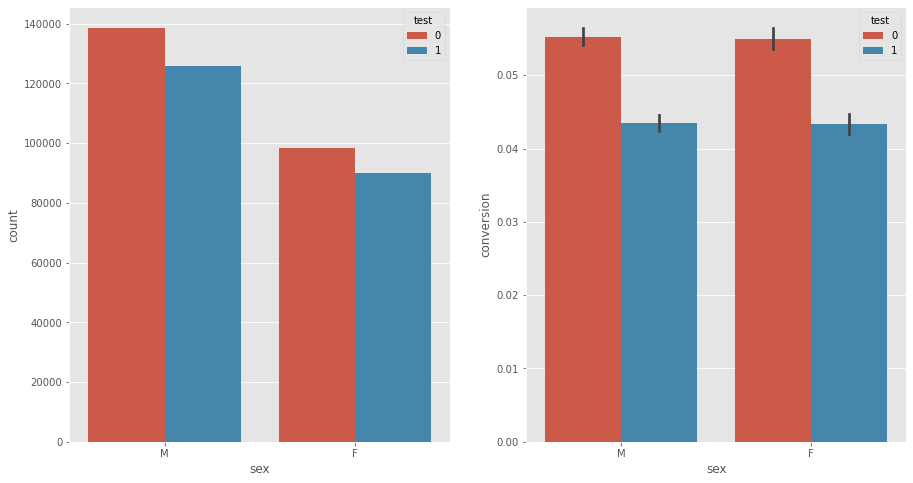

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(15, 8))
sns.countplot(x="sex", hue="test", data=data, ax=ax[0])
sns.barplot(x="sex", y="conversion", hue="test", data=data, ax=ax[1]);

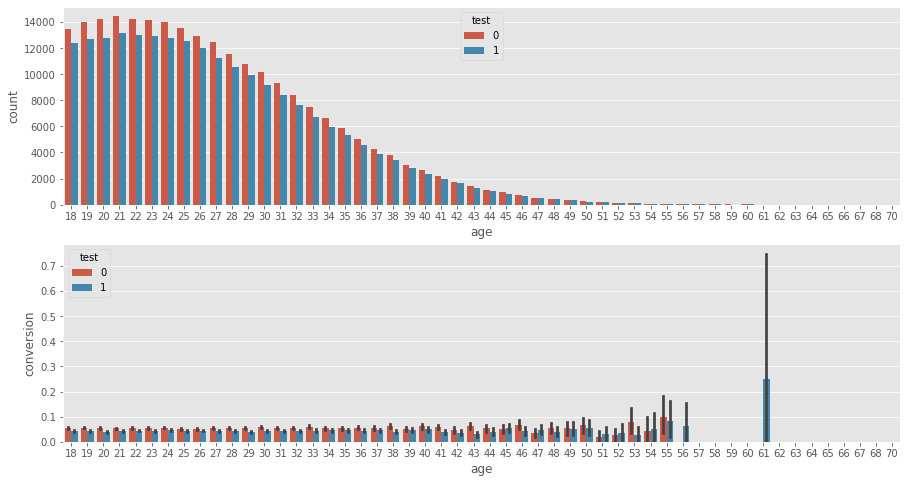

In [19]:
fig, ax = plt.subplots(2, 1, figsize=(15, 8))
sns.countplot(x="age", hue="test", data=data, ax=ax[0])
sns.barplot(x="age", y="conversion", hue="test", data=data, ax=ax[1]);

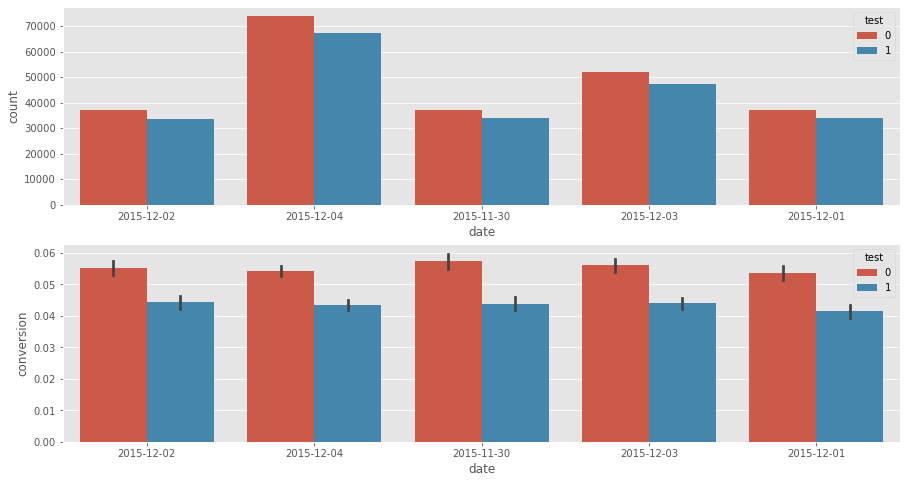

In [20]:
fig, ax = plt.subplots(2, 1, figsize=(15, 8))
sns.countplot(x="date", hue="test", data=data, ax=ax[0])
sns.barplot(x="date", y="conversion", hue="test", data=data, ax=ax[1]);

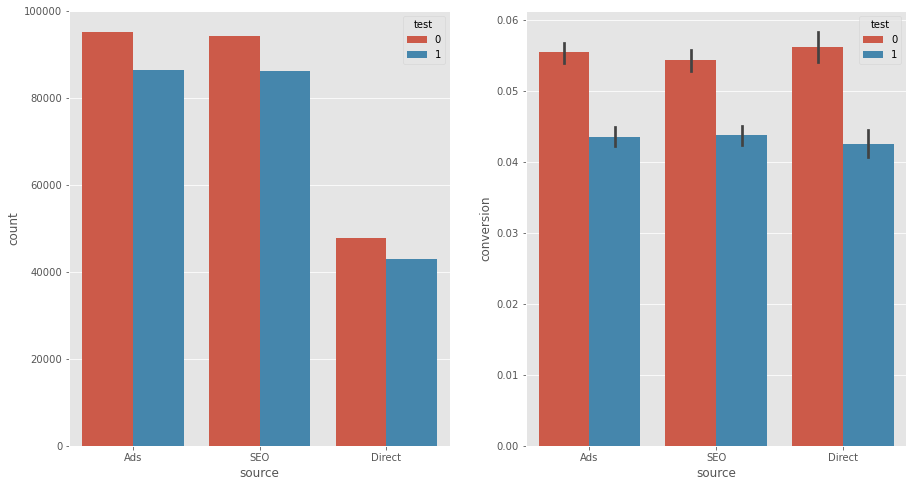

In [21]:
fig, ax = plt.subplots(1, 2, figsize=(15, 8))
sns.countplot(x="source", hue="test", data=data, ax=ax[0])
sns.barplot(x="source", y="conversion", hue="test", data=data, ax=ax[1]);

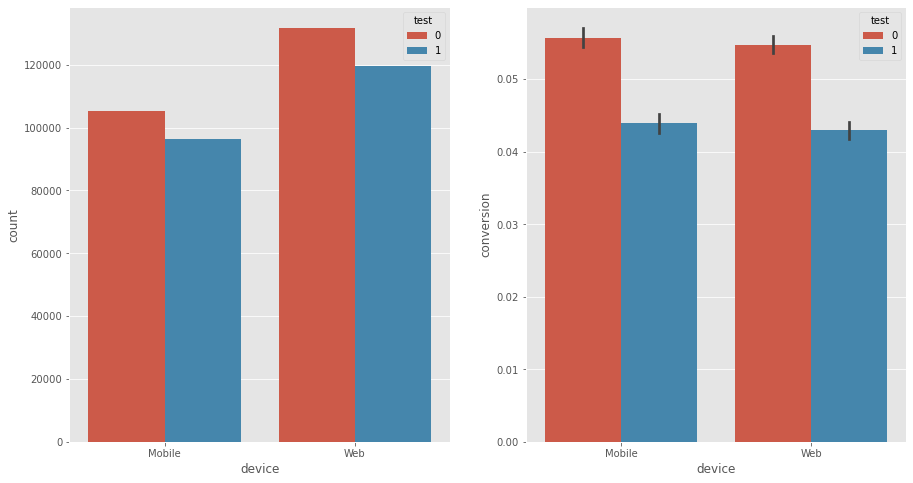

In [22]:
fig, ax = plt.subplots(1, 2, figsize=(15, 8))
sns.countplot(x="device", hue="test", data=data, ax=ax[0])
sns.barplot(x="device", y="conversion", hue="test", data=data, ax=ax[1]);

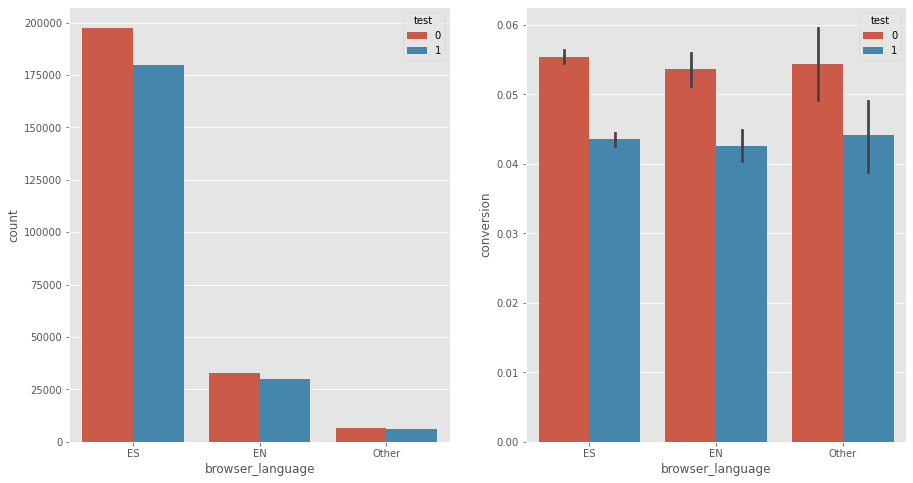

In [23]:
fig, ax = plt.subplots(1, 2, figsize=(15, 8))
sns.countplot(x="browser_language", hue="test", data=data, ax=ax[0])
sns.barplot(x="browser_language", y="conversion", hue="test", data=data, ax=ax[1]);

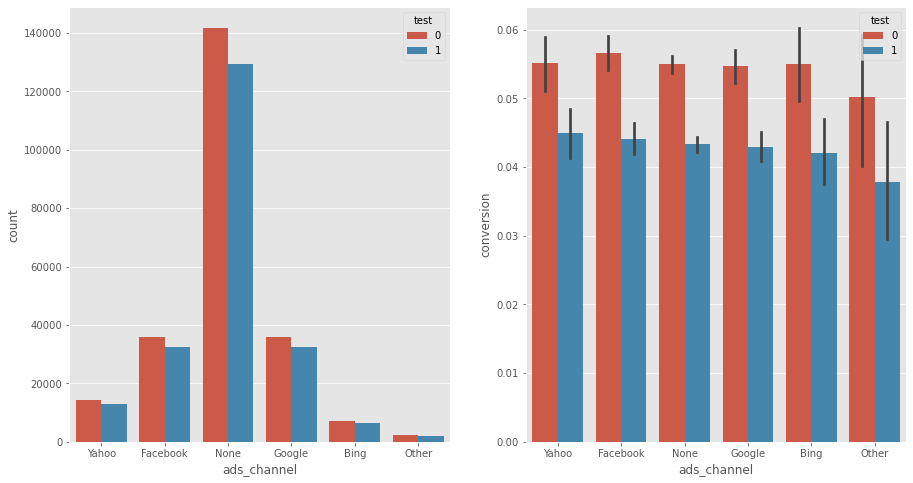

In [24]:
fig, ax = plt.subplots(1, 2, figsize=(15, 8))
sns.countplot(x="ads_channel", hue="test", data=data, ax=ax[0])
sns.barplot(x="ads_channel", y="conversion", hue="test", data=data, ax=ax[1]);

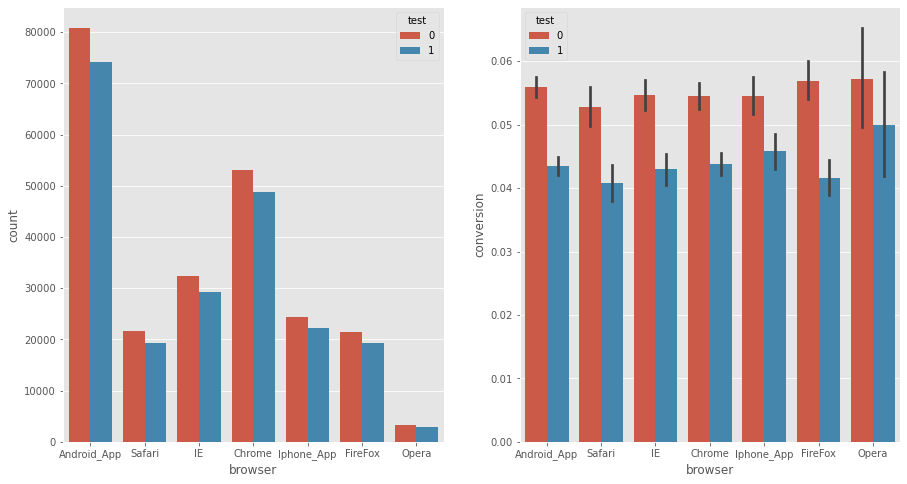

In [25]:
fig, ax = plt.subplots(1, 2, figsize=(15, 8))
sns.countplot(x="browser", hue="test", data=data, ax=ax[0])
sns.barplot(x="browser", y="conversion", hue="test", data=data, ax=ax[1]);

So far we see that the control and treatment sets are distributed consistently across different features.

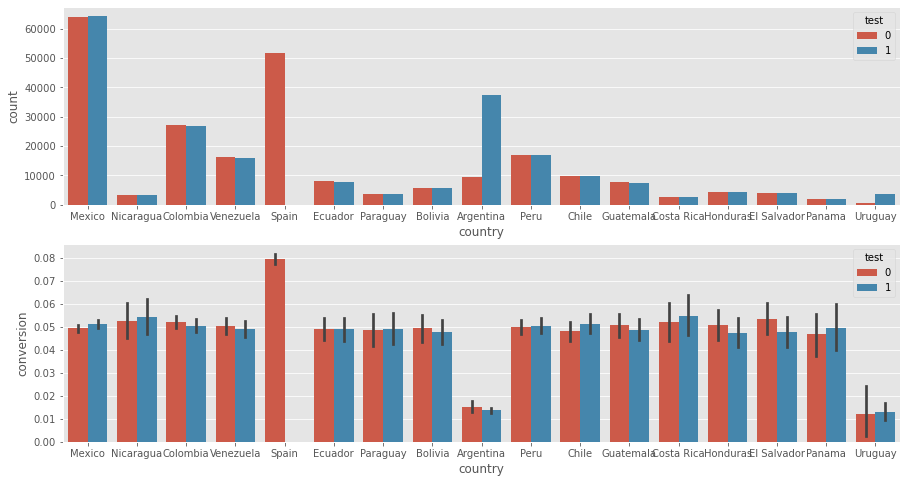

In [26]:
fig, ax = plt.subplots(2, 1, figsize=(15, 8))
sns.countplot(x="country", hue="test", data=data, ax=ax[0])
sns.barplot(x="country", y="conversion", hue="test", data=data, ax=ax[1]);

This is where the data look suspicious. The control and treatment are not consistent in **Argentina** and **Uruguay**.

Let's zoom in to see the difference.

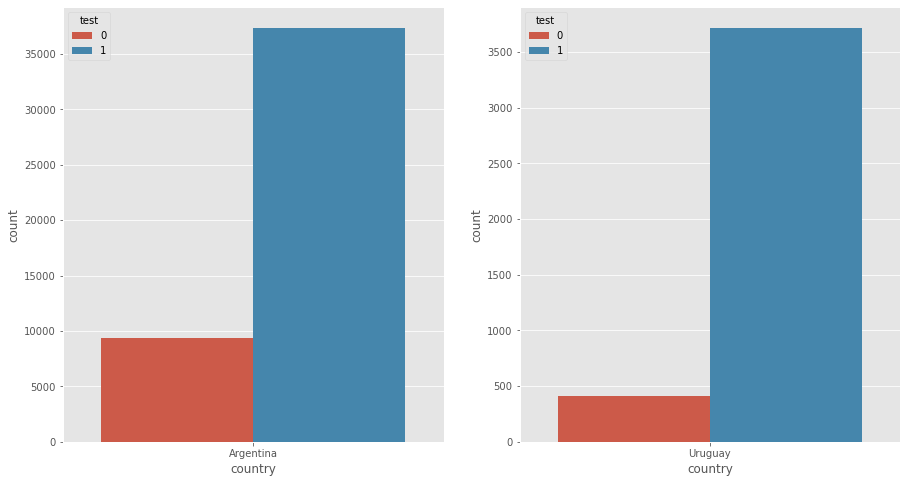

In [27]:
fig, ax = plt.subplots(1, 2, figsize=(15, 8))
sns.countplot(x="country", hue="test", data=data[data["country"] == "Argentina"], ax=ax[0])
sns.countplot(x="country", hue="test", data=data[data["country"] == "Uruguay"], ax=ax[1]);

To reduce the bias, we can remove these countries from our analysis.
Spain is not in the treatment group, since the site was already localized for the Spanish users, so we'll remove it from the control as well.

In [28]:
updated_control = control[(control["country"] != "Argentina") & (control["country"] != "Uruguay") & (control["country"] != "Spain")]
updated_treatment = treatment[(treatment["country"] != "Argentina") & (treatment["country"] != "Uruguay")]

proportion_test(updated_control["conversion"], updated_treatment["conversion"], "", "larger")

Z-statistic: -0.06
p-value: 0.524
ci 95% for control group: [0.049, 0.052]
ci 95% for treatment group: [0.049, 0.052]
Significant:  NO


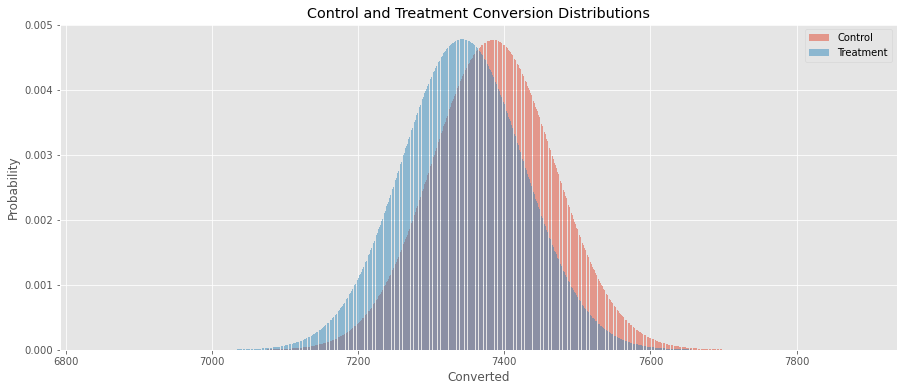

In [29]:
plot_dist(updated_control["conversion"], updated_treatment["conversion"])

Now the proportion test and distribution plots don't indicate any significant difference between the control and treatment groups.

Let's see how the localized versions of the site performed by each country.

In [30]:
countries = treatment["country"].unique()
countries = countries[(countries != "Argentina") & (countries != "Uruguay")]
countries

array(['Mexico', 'Colombia', 'Venezuela', 'Ecuador', 'Guatemala',
       'Costa Rica', 'Bolivia', 'Honduras', 'Nicaragua', 'Peru', 'Chile',
       'El Salvador', 'Panama', 'Paraguay'], dtype=object)

In [31]:
for country in countries:
    c = control[control["country"] == country]["conversion"]
    t = treatment[treatment["country"] == country]["conversion"]
    proportion_test(c, t, country)
    print()

Country:  Mexico
Z-statistic: -0.72
p-value: 0.235
ci 95% for control group: [0.048, 0.052]
ci 95% for treatment group: [0.049, 0.053]
Significant:  NO

Country:  Colombia
Z-statistic: 0.89
p-value: 0.814
ci 95% for control group: [0.050, 0.056]
ci 95% for treatment group: [0.048, 0.054]
Significant:  NO

Country:  Venezuela
Z-statistic: 0.33
p-value: 0.629
ci 95% for control group: [0.047, 0.054]
ci 95% for treatment group: [0.046, 0.054]
Significant:  NO

Country:  Ecuador
Z-statistic: 0.42
p-value: 0.664
ci 95% for control group: [0.045, 0.056]
ci 95% for treatment group: [0.044, 0.054]
Significant:  NO

Country:  Guatemala
Z-statistic: -0.36
p-value: 0.359
ci 95% for control group: [0.045, 0.055]
ci 95% for treatment group: [0.046, 0.057]
Significant:  NO

Country:  Costa Rica
Z-statistic: -0.25
p-value: 0.400
ci 95% for control group: [0.042, 0.061]
ci 95% for treatment group: [0.044, 0.063]
Significant:  NO

Country:  Bolivia
Z-statistic: 0.03
p-value: 0.513
ci 95% for control gr

The tests reveal no significant changes for countries in Latin America.

## Conclusion

When we perform A/B Testing, we need to make sure that we don't have any biases that would affect the results. In this case, we made sure that there are no missing data (**ads_channel**) and that the control and treatment groups are split consistently across different features. Turned out that the number of samples in each group are different enough in **Argentina** and **Uruguay** to introduce bias to our results. Removing those two countries along with **Spain** from our analysis helped us see the real picture of the experiment.